In [1]:
# 필요한 라이브러리 불러오기
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
# tesseract 실행, 경로 설정
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
# 영상 가져오기
cap = cv2.VideoCapture('movecar.mp4')

In [3]:
while True:
    # 영상 읽기 (gray 이미지, 이미지 가우시안 블러, canny edge 처리)
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 10, 70)
    ret, mask = cv2.threshold(canny, 70, 255, cv2.THRESH_BINARY)
    # 화면에 비디오 띄우기
    cv2.imshow('Video feed', mask)
    
    
    # q 키를 누르면 이미지가 저장되고 영상이 종료됨
    if cv2.waitKey(1) == ord('q'):
        cv2.imwrite('img4.jpg', img)
        break
        
cap.release()
cv2.destroyAllWindows()

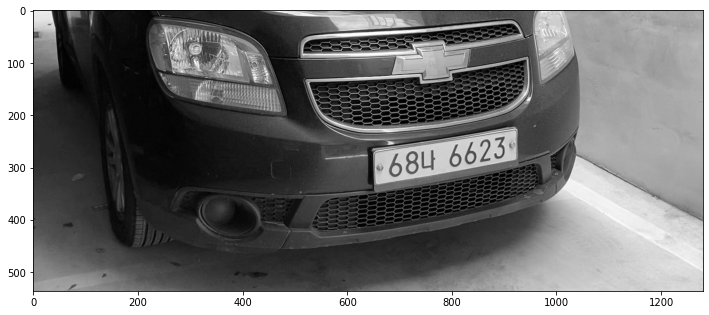

In [4]:
# 이미지 읽고 이미지 정보 불러오기
test = cv2.imread('img4.jpg')
height, width, channel = test.shape

#img는 칼라니까 흑백 이미지로 처리해주기 (grayscale 쓸 수도 있음)
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# 사진 띄우기
plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

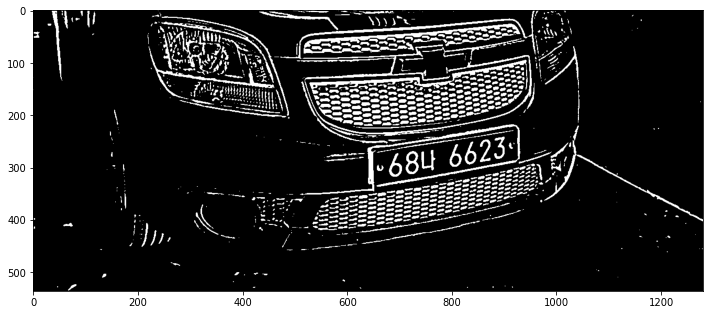

In [14]:
#thresholding ( 가우시안블러 - 노이즈 줄여줌, adaptivethreshold - 이미지 구분 쉽게 만들기)
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
img_canny = cv2.Canny(img_blurred, 10, 70)
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue = 255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

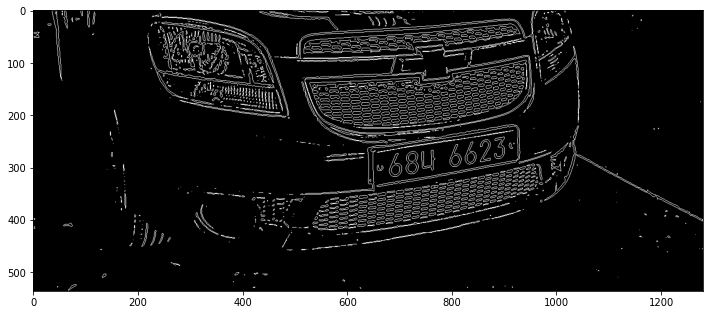

In [15]:
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

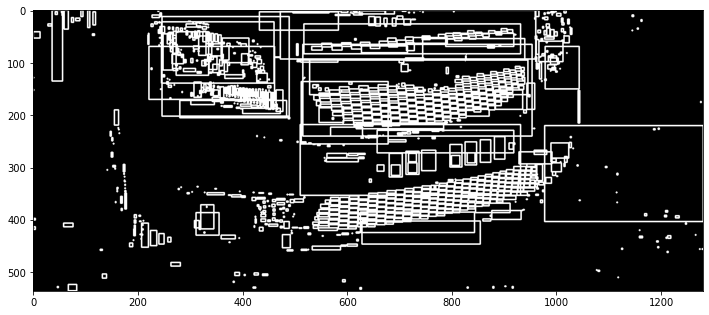

In [16]:
#numpy형 변환
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
# 윤곽선 저장
contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) # 좌표, 넓이, 높이 저장
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2) #바운딩 박스 그리기
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
# cx, cy : 사각형 중심좌표
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

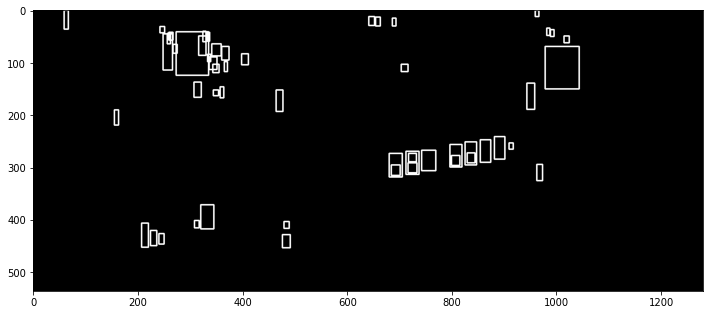

In [17]:
# 글자 크기에 맞게 숫자를 설정 (번호판 한 칸은 세로가 길고, 가로가 짧음)
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 10
MIN_RATIO, MAX_RATIO = 0.2, 1
# 가능한 네모 저장
possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    # 번호판 높은 애들 저장
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# 사용 가능한 윤곽선 표시해주기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

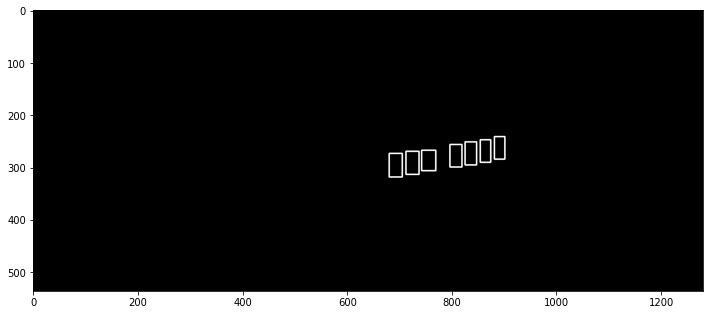

In [24]:
# 번호판은 숫자가 규칙적, 배열 모양을 통해 번호판 위치 찾기
MAX_DIAG_MULTIPLYER = 5 # 윤곽선 중심 끼리 길이, 중심과 중심 5배 안
MAX_ANGLE_DIFF = 12.0 # 윤곽선 중심 끼리 직각삼각형 각
MAX_AREA_DIFF = 0.4 # 둘 사이 면적차이
MAX_WIDTH_DIFF = 0.3 # 둘 사이 너비차이
MAX_HEIGHT_DIFF = 0.25 # 둘 사이 높이차이
MIN_N_MATCHED = 6 # 조건 수(번호판은 7개)

# 번호판 후보 계속 찾기 위해서
def find_chars(contour_list):
    matched_result_idx = [] # 최종적인 배열 모양 인덱스 저장
    
    for d1 in contour_list: # d1, d2 비교
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:  # 같은 건 비교할 필요가 없음
                continue

            dx = abs(d1['cx'] - d2['cx']) # 윤곽선 중심 가지고 계산
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) #직각삼각형 거리,

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0: # d1, d2가 수직으로 있음
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # 각도 값
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) #면적 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] #너비 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] #높이 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx']) # 인덱스 추가

        # append this contour
        matched_contours_idx.append(d1['idx']) #d1 추가

        if len(matched_contours_idx) < MIN_N_MATCHED: #개수 
            continue

        matched_result_idx.append(matched_contours_idx) #맞는 배열

        unmatched_contour_idx = [] # 아닌 배열 골라내기
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx) #안맞는 배열 뽑아내기 np.take
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# 사용가능한 윤곽선 표시해주기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result: # 인덱스 그리기
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

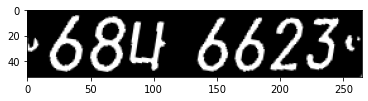

In [27]:
PLATE_WIDTH_PADDING = 1.2 # 번호판 자를 가로
PLATE_HEIGHT_PADDING = 1.25 # 번호판 자를 세로
MIN_PLATE_RATIO = 2.5
MAX_PLATE_RATIO = 8

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result): #x 방향으로 정렬
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    # 기울어져 있는 거 조정, 기울어진 각도 구하기
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    # rotation matrix 구하기
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    # 번호판 부분만 자르기
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

68나6623


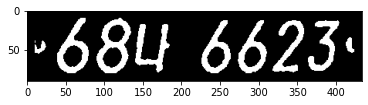

In [28]:
longest_idx, longest_text = -1, 0
plate_chars = []
#thresholding
for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 다시 윤곽선 찾기
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h
        # 설정한 기준에 맞는지 다시 체크
        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
    # 이미지 번호판 부분만 자르기            
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    # 글씨 잘 읽히게 가우시안 블러와 thresholding 한번 더
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    # 검정색 padding을 통해 더 인식을 잘 하 게 해줌

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    # 이미지의 글자 읽기, 언어는 한국어, psm7: 이미지가 한 줄에 있음 (가정), oem:0번 엔진, 0번엔진을 사용하면 한 글자씩 다 인식함
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i


    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')